In [2]:
%cd ..

/home/ai_n_zag@lab.graphicon.ru/tmp/kolobok/ml


In [30]:
from pathlib import Path
import json
from typing import Optional, Callable, Tuple
import random
from functools import partial
from copy import deepcopy
import math

import cv2
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.transforms import v2 as v2_transforms
from torchvision.transforms import functional as VF, InterpolationMode
from torchvision.io import read_image

from matplotlib import pyplot as plt
from tqdm import tqdm

from transformers import SegformerForSemanticSegmentation, SegformerConfig


In [31]:
data_train = Path("data/sidewall/train_processed")
data_val = Path("data/sidewall/val_processed")
backgrounds_root = Path("data/sidewall/backgrounds")

images_name = "images"
targets_name = "masks"
masks_name = "masks_v2"


In [66]:
def upscale_background(background, img):
    *_, h, w = img.shape
    background = VF.resize(
        background, (h * 3 // 2, w * 3 // 2), interpolation=InterpolationMode.BICUBIC
    )

    return background


def random_crop(background, img):
    *_, h, w = img.shape
    transform = transforms.RandomCrop(size=(h, w))
    crop = transform(background)

    return crop


def augment(background):
    transform = transforms.Compose(
        [
            transforms.ColorJitter(
                brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
            ),
            transforms.RandAugment(num_ops=5),
        ]
    )
    background = transform(background)
    return background


def random_replace_background(img, background, mask, multiplier: float = 0.4):
    background = upscale_background(background, img)
    background = random_crop(background, img)
    background = augment(background)

    background = background / 255 * multiplier
    background = v2_transforms.GaussianNoise(0.2)(background)

    return img * mask + background * (1 - mask)

In [67]:
def augment_background(image, mask, background_paths, prob, multiplier):
    if random.random() > prob:
        return image, mask

    background_path = random.choice(background_paths)
    background = read_image(background_path)
    image = random_replace_background(image, background, mask, multiplier)

    return image, mask


def cv2_to_covariance(cx, cy, w, h, angle_deg):
    """
    Converts ellipse parameters from OpenCV's fitEllipse format to a
    covariance-based representation (cx, cy, l11, l21, l22).

    Args:
        cx (float): Center x-coordinate.
        cy (float): Center y-coordinate.
        w (float): Width of the ellipse.
        h (float): Height of the ellipse.
        angle_deg (float): Angle of rotation in degrees.

    Returns:
        Tuple[float, float, float, float, float]: The ellipse representation.
    """
    angle_rad = math.radians(angle_deg)
    # Use major and minor axes to ensure a >= b
    a = max(w, h) / 2.0
    b = min(w, h) / 2.0

    # If width < height, the angle from fitEllipse needs adjustment
    if w < h:
        angle_rad += math.pi / 2

    c, s = math.cos(angle_rad), math.sin(angle_rad)

    # Covariance matrix M = R * diag(a^2, b^2) * R.T
    A = c**2 * a**2 + s**2 * b**2
    B = s * c * (a**2 - b**2)
    C = s**2 * a**2 + c**2 * b**2

    # Cholesky decomposition M = L * L.T, where L = [[l11, 0], [l21, l22]]
    l11 = math.sqrt(A)
    l21 = B / l11 if l11 != 0 else 0
    # Ensure l22 is not negative due to float precision
    l22 = math.sqrt(max(0, C - l21**2))

    return cx, cy, l11, l21, l22


def covariance_to_cv2(cx, cy, l11, l21, l22):
    """
    Converts a covariance-based ellipse representation back to OpenCV's
    fitEllipse format ((cx,cy), (width, height), angle_deg).

    Args:
        cx (float): Center x-coordinate.
        cy (float): Center y-coordinate.
        l11 (float): Cholesky decomposition element.
        l21 (float): Cholesky decomposition element.
        l22 (float): Cholesky decomposition element.

    Returns:
        Tuple[Tuple[float, float], Tuple[float, float], float]: OpenCV ellipse format.
    """
    # Reconstruct covariance matrix M from Cholesky L
    A = l11**2
    B = l11 * l21
    C = l21**2 + l22**2

    # Eigenvalue decomposition to find axes and angle
    T = A + C
    sqrt_discriminant = math.sqrt(max(0, (A - C) ** 2 + 4 * B**2))
    lambda1 = (T + sqrt_discriminant) / 2.0  # Eigenvalue for major axis
    lambda2 = (T - sqrt_discriminant) / 2.0  # Eigenvalue for minor axis

    w = 2 * math.sqrt(max(0, lambda1))  # Major axis length
    h = 2 * math.sqrt(max(0, lambda2))  # Minor axis length

    # Angle is given by 0.5 * atan2(2B, A-C)
    angle_rad = 0.5 * math.atan2(2 * B, A - C)
    angle_deg = math.degrees(angle_rad)

    # Ensure angle is in [0, 180) range
    if angle_deg < 0:
        angle_deg += 180

    return ((cx, cy), (w, h), angle_deg)


class SidewallSegmentationDataset(Dataset):
    def __init__(
        self,
        data_root: Path,
        resize: Optional[Tuple[int, int]] = None,
        aug_fn: Optional[Callable] = None,
        output_ellipse: bool = True,
    ):
        self.image_paths = []
        images_root = data_root / "images"
        masks_root = data_root / "masks"
        self.resize = resize
        self.aug_fn = aug_fn
        self.output_ellipse = output_ellipse

        for image_path in images_root.glob("*.png"):
            image_name = image_path.name
            mask_path = masks_root / image_name

            if not image_path.exists() or not mask_path.exists():
                continue

            self.image_paths.append((image_path, mask_path))

    def _get_ellipse_target(self, mask):
        # Convert to numpy and find the largest contour
        mask_numpy = mask.numpy()[0].astype(np.uint8)
        contours, _ = cv2.findContours(
            mask_numpy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        # Handle cases with no contours or too few points for fitting
        if not contours or len(max(contours, key=cv2.contourArea)) < 5:
            return torch.zeros(5, dtype=torch.float32)

        contour = max(contours, key=cv2.contourArea)

        # Fit ellipse using OpenCV
        (cx, cy), (w, h), angle_deg = cv2.fitEllipse(contour)
        h_mask, w_mask = mask.shape[1:]

        # Normalize center and axes by image dimensions before conversion
        cx_norm = cx / w_mask
        cy_norm = cy / h_mask
        w_norm = w / w_mask
        h_norm = h / h_mask

        # Convert to the robust covariance representation
        _, _, l11, l21, l22 = cv2_to_covariance(
            cx_norm, cy_norm, w_norm, h_norm, angle_deg
        )

        # For better training stability, the network should predict the log of the diagonal
        # elements of the Cholesky matrix, but here we return the direct values.
        # target = [cx_norm, cy_norm, math.log(l11), l21, math.log(l22)]
        return torch.tensor([cx_norm, cy_norm, l11, l21, l22], dtype=torch.float32)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        image_path, mask_path = self.image_paths[idx]
        image = read_image(image_path) / 255
        mask = read_image(mask_path) / 255

        if self.aug_fn is not None:
            print(image.shape, image.min(), image.max(), mask.shape, mask.min(), mask.max())
            image, mask = self.aug_fn(image, mask)

        if self.resize is not None:
            image = VF.resize(
                image, self.resize, interpolation=InterpolationMode.BICUBIC
            )
            mask = VF.resize(mask, self.resize, interpolation=InterpolationMode.NEAREST)

        if self.output_ellipse:
            target = self._get_ellipse_target(mask)
            return image, target
        else:
            return image, mask.to(torch.long)

In [68]:

train_dataset = SidewallSegmentationDataset(
    data_root=data_train,
    resize=(512, 512),
    aug_fn=partial(
        augment_background,
        background_paths=list(backgrounds_root.glob("*.png")),
        prob=0.9,
        multiplier=0.35,
    ),
)
val_dataset = SidewallSegmentationDataset(
    data_root=data_val,
    resize=(512, 512),
)

torch.Size([3, 640, 640]) tensor(0.) tensor(1.) torch.Size([1, 640, 640]) tensor(0.) tensor(1.)
torch.Size([3, 512, 512]) tensor(-0.0361) tensor(1.0238)


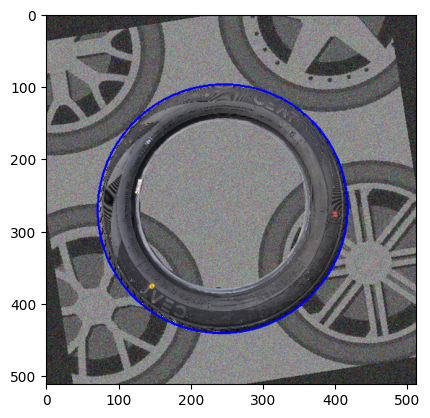

In [70]:
img, ellipse = train_dataset[5]
(cx, cy), (w, h), angle = covariance_to_cv2(*ellipse)
cx = int(cx * img.shape[1])
cy = int(cy * img.shape[2])
w = int(w * img.shape[1])
h = int(h * img.shape[2])
print(img.shape, img.min(), img.max())
img_to_show = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8).copy()

# plt.imshow(img_to_show)

cv2.ellipse(img=img_to_show, box=((cx, cy), (w, h), angle), color=(0, 0, 255), thickness=2)

plt.imshow(img_to_show)

In [42]:
(cx, cy), (w, h), angle

((tensor(258.4465), tensor(257.8134)),
 (488.2602565486976, 479.5126269192502),
 159.16399151253145)

In [50]:
((cx, cy), (w, h), angle)

((258, 257), (488, 479), 159.16399151253145)

In [ ]:
contours, _ = cv2.findContours(mask.numpy()[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour = max(contours, key=lambda c: cv2.contourArea(c))

[[[261  18]]

 [[260  19]]

 [[243  19]]

 ...

 [[277  19]]

 [[276  19]]

 [[275  18]]]


Text(0.5, 1.0, 'Original contour (red) and fitted ellipse (green)')

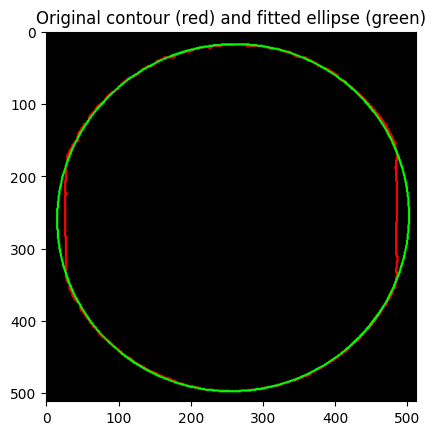

In [ ]:
# Create a visualization image
vis_img = np.zeros(list(mask.shape)[1:] + [3], dtype=np.uint8)

# Draw original contour in red
cv2.drawContours(vis_img, contours, -1, (255, 0, 0), 2)
# Get ellipse parameters and draw it in green
# cv2.fitEllipse returns a tuple of ((center_x, center_y), (width, height), angle)
# where center is the center point of the ellipse, width and height are the axes lengths,
# and angle is the rotation angle in degrees
params = cv2.fitEllipse(contours[0])
cv2.ellipse(vis_img, params, (0, 255, 0), 2)

# Display the visualization
plt.figure()
plt.imshow(vis_img)
plt.title("Original contour (red) and fitted ellipse (green)")

In [25]:
params

((258.44647216796875, 257.8134460449219),
 (479.51263427734375, 488.26025390625),
 69.1639633178711)

In [9]:
class SegformerWrapper(nn.Module):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

    def _upscale_logits(self, logits: torch.Tensor, target_shape: tuple = (512, 512)):
        logits = VF.resize(
            logits, 
            size=target_shape, 
            interpolation=InterpolationMode.BILINEAR,
        )
        return logits

    def forward(self, images: torch.Tensor):
        logits = self.model(images).logits
        # logits = self._upscale_logits(logits, target_shape=images.shape[2:])
        return logits

model_name = "nvidia/segformer-b2-finetuned-ade-512-512"


config = SegformerConfig.from_pretrained(model_name)
config.num_labels = 1  

base_model = SegformerForSemanticSegmentation.from_pretrained(
    model_name,
    config=config,
    ignore_mismatched_sizes=True,
    weights_only=False,
)

model = SegformerWrapper(base_model)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([1, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
def binary_dice_loss(probs: torch.Tensor, labels: torch.Tensor, eps=1e-6):
    """
    logits: [B, C, H, W] raw scores
    labels: [B, H, W] ints in [0..C-1]
    """
    # convert to one-hot: [B, C, H, W]
    # compute per-class dice
    labels = labels.to(probs.dtype)
    intersection = torch.sum(probs * labels, dim=(1, 2))
    union = torch.sum(probs + labels, dim=(1, 2))
    dice = (2 * intersection + eps) / (union + eps)
    return 1 - dice.mean()


def binary_focal_loss(probs: torch.Tensor, labels: torch.Tensor, gamma: float = 2.0):
    """
    logits: [B, C, H, W] raw scores
    labels: [B, H, W] ints in [0..C-1]
    """
    return torch.mean(
        -(labels * torch.log(probs) * (1 - probs) ** gamma)
        - ((1 - labels) * torch.log(1 - probs) * (probs) ** gamma)
    )

def resize_target(logits: torch.Tensor, target: torch.Tensor):
    *_, h, w = logits.shape
    return VF.resize(target, (h, w), interpolation=InterpolationMode.NEAREST)


class BinarySegformerLoss(nn.Module):
    def __init__(self, focal_weight: float = 1, dice_weight: float = 1):
        super().__init__()
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight

    def forward(self, logits: torch.Tensor, labels: torch.Tensor):
        labels = resize_target(logits, labels)
        probs = F.sigmoid(logits.squeeze(1))
        focal = binary_focal_loss(probs, labels)
        dice = binary_dice_loss(probs, labels)
        return self.focal_weight * focal + self.dice_weight * dice

def iou(logits: torch.Tensor, labels: torch.Tensor, threshold: float=0.5, eps: float = 1e-6) -> torch.Tensor:
    labels = resize_target(logits, labels)
    preds_bin = F.sigmoid(logits) > threshold
    labels_bin = labels > 0.5

    intersection = torch.sum(preds_bin & labels_bin, dim=(-2, -1)) + eps
    union = torch.sum(preds_bin | labels_bin, dim=(-2, -1)) + eps

    return intersection / union

In [11]:
def train_fn(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: str,
    n_epochs: int = 5,
):
    model.to(device)
    best_val_metric = -torch.inf
    best_model = deepcopy(model).cpu()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    loss_fn = BinarySegformerLoss()

    for epoch in range(1, n_epochs + 1):
        model.train()
        running_loss = 0
        train_loop = tqdm(train_loader, desc=f"[{epoch}/{n_epochs}] Train Epoch")

        for i, (x, y) in enumerate(train_loop):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            preds_raw = model(x)
            loss = loss_fn(preds_raw, y)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()

            train_loop.set_postfix(loss=running_loss / (i + 1))

        model.eval()
        ious = []
        eval_loop = tqdm(val_loader, desc=f"[{epoch}/{n_epochs}] Evaluation Epoch")

        with torch.no_grad():
            for i, (x, y) in enumerate(eval_loop):
                x = x.to(device)
                y = y.to(device)

                preds_raw = model(x).squeeze(1)
                ious.extend(iou(preds_raw, y).cpu().tolist())

                eval_loop.set_postfix(iou=np.mean(ious), best_iou=best_val_metric)

        val_metric = np.mean(ious)

        if val_metric > best_val_metric:
            best_val_metric = val_metric
            best_model = deepcopy(model).cpu()

    return best_model, val_metric


In [82]:
ckpt_path = "checkpoints/sidewall_unwrapper_0.0000.pt"
ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=True)
model.load_state_dict(ckpt)
model = model.eval()

In [83]:
img = read_image("data/test/input/0.png")[None] / 255
orig_size = img.shape[-2:]
img_resized = VF.resize(img, (512, 512), interpolation=InterpolationMode.BICUBIC)
with torch.no_grad():
    model_output = model(img_resized)
print(model_output.shape)
model_output = VF.resize(model_output, orig_size, interpolation=InterpolationMode.BICUBIC).squeeze()
print(model_output.shape)


torch.Size([1, 1, 128, 128])
torch.Size([1280, 960])


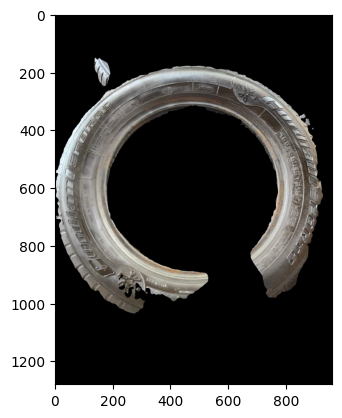

In [84]:
mask = (F.sigmoid(model_output) > 0.5).to(torch.float32)

plt.imshow((img * mask).squeeze().permute(1, 2, 0))

In [85]:
def postprocess_mask(mask_prob, bin_thresh=0.5, min_area=5000, ksize=21):
    """Threshold + close+open + keep largest CC."""
    mask = (mask_prob > bin_thresh).astype(np.uint8) * 255
    kern = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kern)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kern)
    # largest component
    n, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
    if n <= 1: return mask
    areas = stats[1:, cv2.CC_STAT_AREA]; best = 1 + int(np.argmax(areas))
    return (labels == best).astype(np.uint8) * 255

def ellipse_params_from_mask(mask_cc):
    """Fit ellipse to the largest contour of the clean mask."""
    cnts, _ = cv2.findContours(mask_cc, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not cnts: raise RuntimeError("no contour")
    cnt = max(cnts, key=cv2.contourArea)
    # returns ((cx,cy),(major_axis, minor_axis), angle_degrees)
    return cv2.fitEllipse(cnt)

def rectify_and_unwrap(img_bgr, mask_prob):
    """
    1. Clean the mask and fit ellipse.
    2. Compute center=(cx,cy), minor radius=r_minor/2.
    3. If tilt small: skip rectify and warpPolar around (cx,cy,r_minor/2).
       Else: rectify ellipse→circle by rotate+scale, then warpPolar.
    """
    h, w = img_bgr.shape[:2]
    mask_cc = postprocess_mask(mask_prob)
    (cx, cy), (MA, ma), angle = ellipse_params_from_mask(mask_cc)
    cx, cy, MA, ma = float(cx), float(cy), float(MA), float(ma)
    r_minor = ma / 2.0

    # Decide if rectify is needed (e.g. MA/ma > 1.1)
    do_rectify = (MA/ma) > 1.1

    # gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)


    if do_rectify:
        # 1) Rotate by -angle about (cx,cy)
        M_rot = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
        lab = cv2.warpAffine(lab, M_rot, (w, h), flags=cv2.INTER_LINEAR)

        # 2) Scale Y by (ma/MA) to circularize
        scale_y = ma / MA
        # build affine: [1,0,0;0,scale_y, cy*(1-scale_y)]
        M_scale = np.array([[1, 0,           0],
                            [0, scale_y, cy*(1-scale_y)]], dtype=np.float32)
        lab = cv2.warpAffine(lab, M_scale, (w, h), flags=cv2.INTER_LINEAR)

        # After this, ellipse → circle of radius r_minor
        # Center transforms: apply M_scale @ [cx,cy,1]^T then M_rot similarly
        # But for warpPolar we can still use (cx, cy) and r_minor

    # 3) Polar unwrap around (cx,cy) with radius=r_minor
    polar_lab = cv2.warpPolar(
        lab,
        (1000, 3142),
        (cx, cy),
        r_minor,
        flags=cv2.WARP_POLAR_LINEAR
    )

    # 4) Per-angle CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    polar_lab[:,:,0] = clahe.apply(polar_lab[:,:,0])

    rgb = cv2.cvtColor(polar_lab, cv2.COLOR_LAB2BGR)
    
    return rgb

# # --- Example usage ---
# if __name__ == "__main__":
#     img   = cv2.imread("tire.jpg")
#     # mask_prob: float32 mask from your model, same H×W, values in [0,1]
#     mask_prob = your_model_predict(img)  
#     unwrapped = rectify_and_unwrap(img, mask_prob)
#     cv2.imwrite("tire_unwrapped.jpg", unwrapped)

In [86]:
img_numpy = (img * 255).squeeze(0).to(torch.uint8).permute(1, 2, 0).numpy()
logits_numpy = model_output.numpy()

In [87]:
unwrapped = rectify_and_unwrap(img_numpy, logits_numpy)
unwrapped.shape

(3142, 1000, 3)

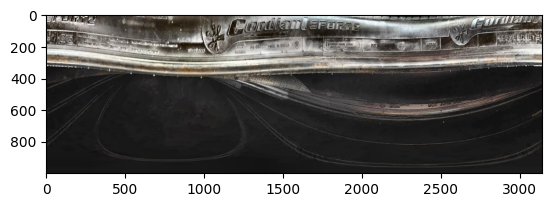

In [88]:
plt.imshow(unwrapped.transpose(1, 0, 2)[::-1])